In [1]:
# the classics
import pandas as pd
import numpy as np
import os 
from scipy import stats
from scipy import optimize
import warnings

# pyCO2sys
import PyCO2SYS as pyco2

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
# symbol and color dictionaries for rivers (R), springs (SP), ponded wetland (P), 
# piezometer wetland (PZ), soil gas (SO)
symdict = dict({'R':'o','SP':'s','P':'^','PZ':'v','SO':'P'})
colordict = dict({'R':'mediumblue','SP':'darkorchid','P':'coral','PZ':'deeppink','SO':'yellowgreen'}) 

This script generates some simple plots of the data, no model outputs here. The dataframe it needs is "df_merged" which includes the chemical data (with PyCO2SYS calculations) and mapped data

In [2]:
df = pd.read_csv('data/watersamples_merged.csv',parse_dates=['datetime'],na_values=['nan','NAN','ibid'])

dflength = len(df)
truepco2length = len(df[~np.isnan(df['pCO2_ppmv'])])
allpco2length = len(df[~np.isnan(df['pco2'])])

print(f'Out of {dflength} total samples, {truepco2length} we measured pCO2 using headspace method,')
print(f'Out of {dflength} total samples, an additional {allpco2length-truepco2length} had pH and alk measurements for calculation of pco2')
print(f'Out of {dflength} total samples, {dflength-allpco2length} do not have any pCO2 reported')

# ### set errors
pco2_error = 0.066 # relative SD
d13c_error = 0.12 # absolute SD
# rn error is individual 
alk_error = 0.10 # relative SD
doc_error = 0.05 # relative SD

Out of 63 total samples, 40 we measured pCO2 using headspace method,
Out of 63 total samples, an additional 18 had pH and alk measurements for calculation of pco2
Out of 63 total samples, 5 do not have any pCO2 reported


In [3]:
## we need the error in DIC concentration at the outlet so we can compute adveective fluxes later
print(f"DIC error at the outlet is {round(df.loc[df['sample_name']=='ER23-23','u_dic_calc_alk_pco2'].item()/1e3,4)} mM")

DIC error at the outlet is 0.0305 mM


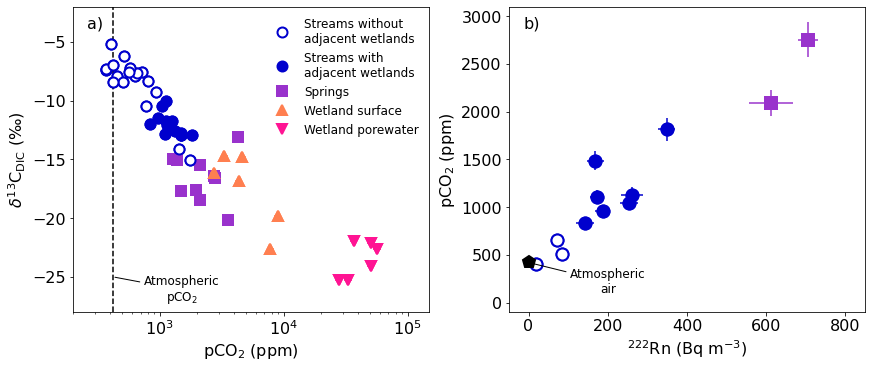

In [11]:
plt.rcParams.update({'font.size': 16,
                    'lines.markersize':10,
                    'lines.markeredgewidth':2})


fig,ax = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)


### plot DIC isotopes vs. DIC
# colordict = dict({'R':'darkblue','SP':'purple','P':'maroon','PZ':'deeppink','SO':'olive'})


# divide up rivers
rivers = df.loc[(df['sample_type']=='R'),:].copy()
rivers['distance_km'] = rivers['distance']/1000

rivers_nowet = rivers.loc[rivers['wetland']!=1,:]
rivers_wet = rivers.loc[rivers['wetland']==1,:]


# define other sample groups
pzs = df.loc[df['sample_type']=='PZ',:]
springs = df.loc[df['sample_type']=='SP',:]


ponds = df.loc[df['sample_type']=='P',:]


### plot d13C vs. pCO2
ax[0].plot(rivers_nowet['pco2'],rivers_nowet['d13C_permil'],ls='',marker='o',markeredgecolor=colordict['R'],markerfacecolor='white',)
ax[0].plot(rivers_wet['pco2'],rivers_wet['d13C_permil'],ls='',marker='o',c=colordict['R'])
ax[0].plot(springs['pco2'],springs['d13C_permil'],c=colordict['SP'],alpha=1,ls='',marker=symdict['SP'])
ax[0].plot(ponds['pco2'],ponds['d13C_permil'],c=colordict['P'],alpha=1,ls='',marker=symdict['P'])
ax[0].plot(pzs['pco2'],pzs['d13C_permil'],c=colordict['PZ'],alpha=1,ls='',marker=symdict['PZ'])

# errorbars are usually smaller than marker size for pco2 and di13c, just double check here
ax[0].errorbar(rivers_nowet['pco2'],rivers_nowet['d13C_permil'],ls='',xerr=pco2_error*rivers_nowet['pco2'],yerr=d13c_error,marker='o',markeredgecolor=colordict['R'],markerfacecolor='white',)
ax[0].errorbar(rivers_wet['pco2'],rivers_wet['d13C_permil'],ls='',xerr=pco2_error*rivers_wet['pco2'],yerr=d13c_error,marker='o',c=colordict['R'])
ax[0].errorbar(ponds['pco2'],ponds['d13C_permil'],c=colordict['P'],xerr=pco2_error*ponds['pco2'],yerr=d13c_error,alpha=1,ls='',marker=symdict['P'])
ax[0].errorbar(pzs['pco2'],pzs['d13C_permil'],xerr=pco2_error*pzs['pco2'],yerr=d13c_error,c=colordict['PZ'],alpha=1,ls='',marker=symdict['PZ'])

### plot pCO2 vs. Rn
ax[1].plot(rivers_nowet['Rn_bq_m3'],rivers_nowet['pco2'],ls='',marker='o',markersize=12,c=colordict['R'],markerfacecolor='w',)
ax[1].plot(rivers_wet['Rn_bq_m3'],rivers_wet['pco2'],ls='',marker='o',markersize=12,c=colordict['R'])
ax[1].plot(springs['Rn_bq_m3'],springs['pco2'],ls='',markersize=12,c=colordict['SP'],marker=symdict['SP'])

# check for errorbars
ax[1].errorbar(rivers_nowet['Rn_bq_m3'],rivers_nowet['pco2'],xerr=rivers_nowet['Rn_sterror'],yerr=pco2_error*rivers_nowet['pco2'],ls='',marker='o',markersize=12,c=colordict['R'],markerfacecolor='w',)
ax[1].errorbar(rivers_wet['Rn_bq_m3'],rivers_wet['pco2'],xerr=rivers_wet['Rn_sterror'],yerr=pco2_error*rivers_wet['pco2'],ls='',marker='o',markersize=12,c=colordict['R'])
ax[1].errorbar(springs['Rn_bq_m3'],springs['pco2'],xerr=springs['Rn_sterror'],yerr=pco2_error*springs['pco2'],ls='',markersize=12,c=colordict['SP'],marker=symdict['SP'])

# add in atmosphere
ax[0].axvline(420,ls='--',c='k')
ax[0].annotate(text='Atmospheric\npCO$_{2}$',xy=(420,-25),xytext=(1500,-27),arrowprops=dict(arrowstyle= '-',color='k'),
               ha='center',zorder=3,fontsize=12)
ax[1].plot(0,420,ls='',markersize=12,c='k',marker='p',zorder=3)
ax[1].annotate(text='Atmospheric\nair',xy=(0,420),xytext=(200,100),arrowprops=dict(arrowstyle= '-',color='k'),
               ha='center',zorder=3,fontsize=12)

# adjust plot
ax[0].set_xlim([200,1.5e5])
ax[0].set_ylim([-28,-2])
ax[1].set_xlim([-50,850])
ax[1].set_ylim([-100,3100])

# legend and labels
ax[0].legend(['Streams without\nadjacent wetlands','Streams with\nadjacent wetlands','Springs','Wetland surface','Wetland porewater'],
             frameon=False,ncol=1,fontsize=12)

ax[0].set_xlabel('pCO$_{2}$ (ppm)')
ax[0].set_ylabel(r'$\delta^{13}$C$_{\mathrm{DIC}}$ (‰)')
ax[1].set_ylabel('pCO$_{2}$ (ppm)')
ax[1].set_xlabel('$^{222}$Rn (Bq m$^{-3}$)')

# other labels
ax[0].text(0.04,0.93,'a)',transform=ax[0].transAxes,fontsize=16)
ax[1].text(0.04,0.93,'b)',transform=ax[1].transAxes,fontsize=16)

ax[0].set_xscale('log')


fig.savefig('plots/Fig2_two_biplots.pdf')

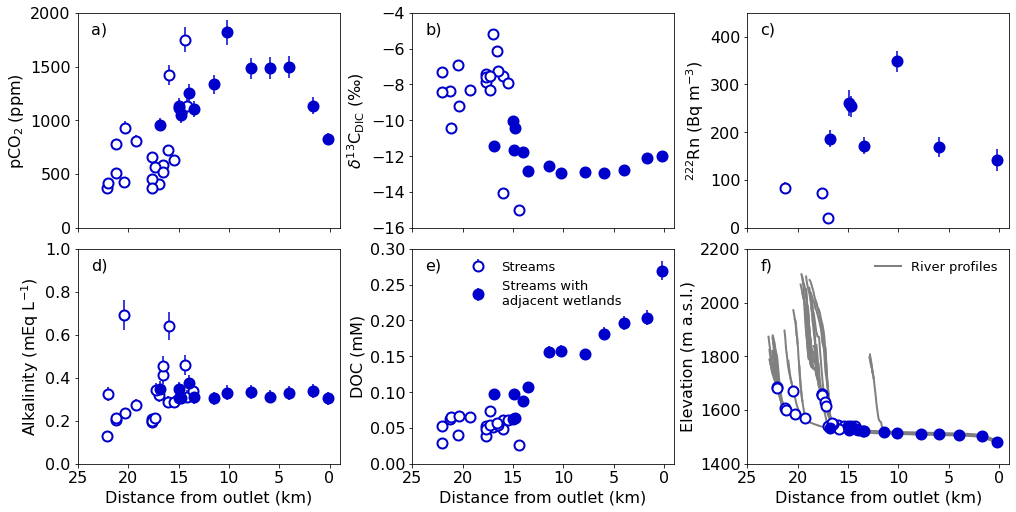

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16,
                    'lines.markersize':10,
                     'lines.markeredgewidth':2})

fig,ax=plt.subplots(2,3,figsize=(14,7),sharex=True,constrained_layout=True)
ax = ax.flatten()



markers=['^','s']


# pco2
ax[0].errorbar(rivers_nowet['distance_km'],rivers_nowet['pco2'],yerr=pco2_error*rivers_nowet['pco2'],marker='o',ls='',markeredgecolor=colordict['R'],markerfacecolor='w',c=colordict['R'])
ax[0].errorbar(rivers_wet['distance_km'],rivers_wet['pco2'],yerr=pco2_error*rivers_wet['pco2'],marker='o',ls='',c=colordict['R'])

# d13c
ax[1].errorbar(rivers_nowet['distance_km'],rivers_nowet['d13C_permil'],yerr=d13c_error,marker='o',ls='',c=colordict['R'],markeredgecolor=colordict['R'],markerfacecolor='w')
ax[1].errorbar(rivers_wet['distance_km'],rivers_wet['d13C_permil'],yerr=d13c_error,marker='o',ls='',c=colordict['R'])

# Rn
ax[2].errorbar(rivers_nowet['distance_km'],rivers_nowet['Rn_bq_m3'],yerr=rivers_nowet['Rn_sterror'],marker='o',ls='',c=colordict['R'],markeredgecolor=colordict['R'],markerfacecolor='w')
ax[2].errorbar(rivers_wet['distance_km'],rivers_wet['Rn_bq_m3'],yerr=rivers_wet['Rn_sterror'],marker='o',ls='',c=colordict['R'])

#Alk
ax[3].errorbar(rivers_nowet['distance_km'],rivers_nowet['Alkalinity_meq_L'],yerr=alk_error*rivers_nowet['Alkalinity_meq_L'],marker='o',ls='',markeredgecolor=colordict['R'],markerfacecolor='w',c=colordict['R'])
ax[3].errorbar(rivers_wet['distance_km'],rivers_wet['Alkalinity_meq_L'],yerr=alk_error*rivers_wet['Alkalinity_meq_L'],marker='o',ls='',c=colordict['R'])

# DOC
ax[4].errorbar(rivers_nowet['distance_km'],rivers_nowet['DOC_mg_L']/12,yerr=doc_error*rivers_nowet['DOC_mg_L']/12,marker='o',ls='',c=colordict['R'],markeredgecolor=colordict['R'],markerfacecolor='w')
ax[4].errorbar(rivers_wet['distance_km'],rivers_wet['DOC_mg_L']/12,yerr=doc_error*rivers_wet['DOC_mg_L']/12,marker='o',ls='',c=colordict['R'])

# labels
ax[0].set_ylabel('pCO$_{2}$ (ppm)')
ax[1].set_ylabel(r'$\delta^{13}$C$_{\mathrm{DIC}}$ (‰)')
ax[2].set_ylabel('$^{222}$Rn (Bq m$^{-3}$)')
ax[3].set_ylabel('Alkalinity (mEq L$^{-1}$)')
ax[4].set_ylabel('DOC (mM)')

ax[3].set_xlabel('Distance from outlet (km)')
ax[4].set_xlabel('Distance from outlet (km)')


# reverse x axis so outlet is on the right side of the plot
ax[1].set_xlim([-1,25])
ax[1].set_xticks([0,5,10,15,20,25])
ax[1].invert_xaxis()

# other labels
ax[0].text(0.05,0.90,'a)',transform=ax[0].transAxes,fontsize=16)
ax[1].text(0.05,0.90,'b)',transform=ax[1].transAxes,fontsize=16)
ax[2].text(0.05,0.90,'c)',transform=ax[2].transAxes,fontsize=16)
ax[3].text(0.05,0.90,'d)',transform=ax[3].transAxes,fontsize=16)
ax[4].text(0.05,0.90,'e)',transform=ax[4].transAxes,fontsize=16)
ax[5].text(0.05,0.90,'f)',transform=ax[5].transAxes,fontsize=16)

ax[3].set_ylim([0,1])
ax[0].set_ylim([0,2000])
ax[1].set_ylim([-16,-4])
ax[2].set_ylim([0,450])
ax[4].set_ylim([0,0.3])
ax[5].set_ylim([1400,2200])



#### read in the network file so we can get the individual stream profiles
net=pd.read_csv('map/network_merged.csv')

plottedone=False
for i in range(1,6):
    
    temp = net.loc[net['strahler']==i,:]
    
    if i<4:
        tempcolor='gray'
        tempalpha=1
        templw=2
    else:
        tempcolor='gray'
        tempalpha=1
        templw=4
        
    tempstreamlist = set(temp['stream'])
    
    for j in tempstreamlist:
        temptemp = temp.loc[temp['stream']==j,:]
        
        if plottedone==False:
            label=''
            plottedone=True
        else:
            label='_nolegend_'
            
        ax[5].plot(temptemp['distance']/1000,temptemp['elev_m'],c=tempcolor,alpha=tempalpha,lw=templw,zorder=0,label=label)
        
    

# plot on elevation plot
ax[5].plot(rivers_nowet['distance_km'],rivers_nowet['elev_m'],marker='o',ls='',c=colordict['R'],markeredgecolor=colordict['R'],markerfacecolor='w')
ax[5].plot(rivers_wet['distance_km'],rivers_wet['elev_m'],marker='o',ls='',c=colordict['R'])

# label
ax[5].set_xlabel('Distance from outlet (km)')
ax[5].set_ylabel('Elevation (m a.s.l.)')

# legends
ax[4].legend(['Streams','Streams with\nadjacent wetlands'],frameon=False,fontsize=13,loc='upper center')
ax[5].legend(['River profiles'],frameon=False,fontsize=13)

fig.savefig('plots/Fig3_downstream_distance.pdf')

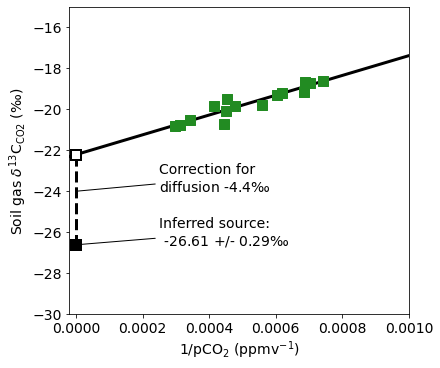

In [6]:
### plot soil CO2 keeling plot
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14,
                    'lines.markersize':10,
                     'lines.markeredgewidth':2})

## plot soil Keeling
soil = pd.read_csv('data/soil_gas.csv')

fig,ax=plt.subplots(1,1,figsize=(6,5),constrained_layout=True)
ax.scatter(1/soil['pCO2_ppmv'],soil['d13C_permil'],s=100,c='forestgreen',marker='s')
x = 1/soil['pCO2_ppmv']
y = soil['d13C_permil']
nanmask = np.isnan(x) | np.isnan(y)


res = stats.linregress(x[~nanmask],y[~nanmask])
xplot = np.arange(-0.01,0.004,0.00001)
ax.plot(xplot,res.slope*xplot+res.intercept,c='k',ls='-',zorder=0,lw=3)
ax.plot(0,res.intercept,markeredgecolor='k',marker='s',markerfacecolor='w')
ax.plot(0,res.intercept-4.4,c='k',marker='s')
ax.plot([0,0],[res.intercept,res.intercept-4.4],c='k',ls='--',lw=3,zorder=0)

ax.set_xlim([-0.00002,0.001])
ax.set_ylim([-30,-15])

ax.set_xlabel('1/pCO$_{2}$ (ppmv$^{-1}$)')
ax.set_ylabel(r'Soil gas $\delta^{13}$C$_{\mathrm{CO2}}$ ($\perthousand$)')

ax.annotate(f'Correction for\ndiffusion -4.4$\perthousand$',xy=[0,-24],xytext=[0.00025,-24],arrowprops=dict(arrowstyle= '-',color='k'))
ax.annotate(f'Inferred source:\n {round(res.intercept-4.4,2)} +/- {round(res.intercept_stderr,2)}$\perthousand$',xy=[0,res.intercept-4.4],xytext=[0.00025,res.intercept-4.4],arrowprops=dict(arrowstyle= '-',color='k'))

fig.savefig('plots/FigS4_keelingsoil.pdf',facecolor='white', transparent=False)

In [7]:
### make a table...
df_pre = df.copy() # make a duplicate just to convert DIC and DOC to mM 

df_pre['DIC_mg_L'] = df['DIC_mg_L']/12
df_pre['DOC_mg_L'] = df['DOC_mg_L']/12

rivers = df_pre.loc[((df_pre['sample_type']=='R')),:]
ponds = df_pre.loc[((df_pre['sample_type']=='P')),:]
pzs = df_pre.loc[((df_pre['sample_type']=='PZ')),:]
springs = df_pre.loc[df['sample_type']=='SP',:]

## df indices
indexnames = ['temperature_deg_C','pH','DIC_mg_L','DOC_mg_L','Alkalinity_meq_L','pco2','d13C_permil','d13c_co2','Rn_bq_m3']

## Table 1 column names 
columnnames = ['Temperature (deg C)','pH','DIC (mM)','DOC (mM)','Alkalinity (mEq/L)','pCO$_{2}$ (ppmv)',r'$\delta^{13}$C ($\perthousand$) ',r'$\delta^{13}$C-CO$_{2}$ ($\perthousand$)',r'$^{222}$Rn (Bq m$^{-3}$)']

# make table 1
table = pd.DataFrame(index=['Streams','Springs','Wetland ponded','Wetland porewater'])

## rivers
# length of df: number of samples
river_length = len(rivers[indexnames])
table.loc['Streams','Number'] = str(int(river_length))

# means mins and maxes
river_means = np.nanmean(rivers[indexnames],axis=0)
river_mins = np.nanmin(rivers[indexnames],axis=0)
river_maxs = np.nanmax(rivers[indexnames],axis=0)

# round to two sigfigs
table.loc['Streams',columnnames] = [f'{round(river_means[i],2)} ({round(river_mins[i],2)} - {round(river_maxs[i],2)})' for i in range(0,len(river_means)) ]
table.loc['Streams','pCO$_{2}$ (ppmv)'] = f'{int(round(river_means[5],0))} ({int(np.round(river_mins[5],0))} - {int(np.round(river_maxs[5],0))})'
table.loc['Streams',r'$^{222}$Rn (Bq m$^{-3}$)'] = f'{int(round(river_means[8],0))} ({int(np.round(river_mins[8],0))} - {int(np.round(river_maxs[8],0))})'


## springs
spring_length = int(len(springs[indexnames]))
table.loc['Springs','Number'] = str(int(spring_length))

spring_means = np.nanmean(springs[indexnames],axis=0)
spring_mins = np.nanmin(springs[indexnames],axis=0)
spring_maxs = np.nanmax(springs[indexnames],axis=0)

table.loc['Springs',columnnames] = [f'{spring_means[i]:.2f} ({spring_mins[i]:.2f} - {spring_maxs[i]:.2f})' for i in range(0,len(spring_means)) ]
table.loc['Springs','pCO$_{2}$ (ppmv)'] = f'{int(round(spring_means[5],0))} ({int(np.round(spring_mins[5],0))} - {int(np.round(spring_maxs[5],0))})'
table.loc['Springs',r'$^{222}$Rn (Bq m$^{-3}$)'] = f'{int(round(spring_means[8],0))} ({int(np.round(spring_mins[8],0))} - {int(np.round(spring_maxs[8],0))})'

## ponded wetlands
pond_length = int(len(ponds[indexnames]))
table.loc['Wetland ponded','Number'] = str(int(pond_length))


# ponds have no Rn data, ignore errors for ~ all nan slices ~
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    pond_means = np.nanmean(ponds[indexnames],axis=0)
    pond_mins = np.nanmin(ponds[indexnames],axis=0)
    pond_maxs = np.nanmax(ponds[indexnames],axis=0)

table.loc['Wetland ponded',columnnames] = [f'{pond_means[i]:.2f} ({pond_mins[i]:.2f} - {pond_maxs[i]:.2f})' for i in range(0,len(pond_means)) ]
table.loc['Wetland ponded','pCO$_{2}$ (ppmv)'] = f'{int(round(pond_means[5],0))} ({int(np.round(pond_mins[5],0))} - {int(np.round(pond_maxs[5],0))})'

# piezometer wetlands
pz_length = int(len(pzs[indexnames]))
table.loc['Wetland porewater','Number'] = str(int(pz_length))

# pzs have no Rn data, ignore errors for ~ all nan slices ~
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    pz_means = np.nanmean(pzs[indexnames],axis=0)
    pz_mins = np.nanmin(pzs[indexnames],axis=0)
    pz_maxs = np.nanmax(pzs[indexnames],axis=0)

table.loc['Wetland porewater',columnnames] = [f'{pz_means[i]:.2f} ({pz_mins[i]:.2f} - {pz_maxs[i]:.2f})' for i in range(0,len(pz_means)) ]
table.loc['Wetland porewater','pCO$_{2}$ (ppmv)'] = f'{int(round(pz_means[5],0))} ({int(np.round(pz_mins[5],0))} - {int(np.round(pz_maxs[5],0))})'

table.to_csv('tables/Table1.csv')

table

,Number,Temperature (deg C),pH,DIC (mM),DOC (mM),Alkalinity (mEq/L),pCO$_{2}$ (ppmv),$\delta^{13}$C ($\perthousand$),$\delta^{13}$C-CO$_{2}$ ($\perthousand$),$^{222}$Rn (Bq m$^{-3}$)
Streams,34,7.6 (4.58 - 12.0),7.31 (6.93 - 7.96),0.45 (0.26 - 0.75),0.09 (0.03 - 0.27),0.32 (0.13 - 0.69),926 (366 - 1818),-9.92 (-15.03 - -5.2),-20.36 (-25.22 - -16.68),171 (20 - 348)
Springs,11,5.74 (4.40 - 7.50),7.01 (6.57 - 7.38),0.89 (0.58 - 1.53),0.03 (0.02 - 0.06),0.46 (0.16 - 0.65),2373 (1281 - 4268),-16.63 (-20.13 - -13.06),-26.06 (-28.60 - -21.26),659 (613 - 706)
Wetland ponded,7,14.69 (6.10 - 25.60),6.59 (6.20 - 7.07),1.19 (0.58 - 2.95),1.01 (0.07 - 1.92),0.39 (0.26 - 0.53),5303 (2722 - 8988),-18.17 (-22.64 - -14.70),-24.85 (-28.74 - -22.15),nan (nan - nan)
Wetland porewater,6,14.68 (10.70 - 19.80),5.92 (5.70 - 6.11),2.79 (2.13 - 3.82),0.88 (0.31 - 1.72),0.54 (0.40 - 0.76),42525 (27895 - 56662),-23.55 (-25.30 - -21.91),-27.13 (-29.73 - -25.10),nan (nan - nan)


In [8]:
%%writefile helperfunctions.py

import numpy as np
from scipy import optimize

def schmidtco2(tinc):# from the newer Wanninkhof 2014
    return 1923.6 -125.06*tinc+4.3773*tinc**2-0.085681*tinc**3+0.00070284 *tinc**4

def schmidtrn(tinc):# from the newer Wanninkhof 2014
    return 3171-224.28*tinc+8.2809 *tinc**2 -0.16699 *tinc**3+0.0013915 *tinc**4

def henryco2(tinc): # this is copied from Conroy 2023
    A = 108.3865# constant 
    B = 0.01985076 # constant 
    C = -6919.53 # constant 
    D = -40.4515 # constant 
    E = 669365 # constant 
    
    tempk =tinc+273.15
    
    return 10**(A+B*tempk+C/tempk+D*np.log10(tempk)+E/tempk**2)


def r2delta(r):
    pdb = 0.011180 
    output = ((r/pdb)-1)*1000
    return output

def delta2r(delta):
    pdb = 0.011180 
    output = pdb*(delta/1000+1)
    return output
   
        

def phfromalk(DIC,alk,tinc):
    tink = tinc + 273.15

   # % k1 values for CO2(d) and HCO3- Harned and Davis Jr 1943
    logk1 = -3404.71/tink + 14.8435 - 0.032786*tink
    
    #% k2 values for HCO3- and CO3-- Harned and Scholes Jr 1941
    logk2 = -2902.39/tink + 6.4980 - 0.02379*tink
    
 #   % Ionozation constant of H2O Millero et al. 1987 and Millero 1995
    pKw = -np.log10(np.exp(148.9802 - 13847.26/tink - 23.6521*np.log(tink))) # assuming zero ionic strength and zero salinity
    
    k1 = 10**logk1
    k2 = 10**logk2
    
    def henryco2(tinc): # this is copied from Conroy 2023
        A = 108.3865# constant 
        B = 0.01985076 # constant 
        C = -6919.53 # constant 
        D = -40.4515 # constant 
        E = 669365 # constant 

        tempk =tinc+273.15
    
        return 10**(A+B*tempk+C/tempk+D*np.log10(tempk)+E/tempk**2)



    
    def getph (modelph):
        pH = modelph
        pOH = pKw - pH
        H = 10**-pH
        OH = 10**-pOH
        modelAlk = DIC * (k1*H) / (H**2 + k1*H + k1*k2) + 2*DIC * (k1*k2) / (H**2 + k1*H + k1*k2) + OH - H
        ErrorVector = modelAlk - alk
        sse = ErrorVector ** 2
        modelpH = pH
        modelpOH = pOH
        
        return sse

    ph_solution = optimize.fmin(func=getph, x0=[6],disp=False)
    
    dco2_solution = alk/(k1/(10**-ph_solution)+2*k1*k2/((10**-ph_solution)**2))
    
    bicarb_solution = dco2_solution*k1/10**-ph_solution
    
    carb_solution = dco2_solution*k1*k2/((10**-ph_solution)**2)

    pco2_solution=1e6*dco2_solution/henryco2(tinc)
        
    return [ph_solution,dco2_solution,bicarb_solution,carb_solution,pco2_solution]


def epsilon_dic_co2(dic,alk,d13c,tinc): ## From Campeau et al., 2017
    [ph,co2,bicarb,carb,pco2] = phfromalk(dic,alk,tinc)
    
    e_bg = -0.1141*tinc+10.78
    e_dg = 0.0049*tinc-1.31
    e_db = e_dg-e_bg
    
    e_cg = -0.052*tinc+7.22
    e_cb = e_cg-e_bg/(1+e_db*10**-3)
    
    d13c_bicarb =(d13c*(dic)-(e_db*co2+e_cb*carb))/((1+e_db*10**-3)*co2+bicarb+(1+e_cb*10**-3)*carb)
      
    d13c_co2 = d13c_bicarb-(1+e_db*10**-3)+e_db
    
    return d13c_co2[0]

def epsilon_co2_dic(dic,alk,d13c,tinc): ## From Campeau et al., 2017
    [ph,co2,bicarb,carb,pco2] = phfromalk(dic,alk,tinc)
    
    e_bg = -0.1141*tinc+10.78
    e_dg = 0.0049*tinc-1.31
    e_db = e_dg-e_bg
    
    e_cg = -0.052*tinc+7.22
    e_cb = e_cg-e_bg/(1+e_db*10**-3)
    
    d13c_bicarb = d13c+(1+e_db*10**-3)-e_db
    d13c_carb = d13c_bicarb-(1+e_cb*10**-3)+e_cb
    d13c_total = (co2*d13c+bicarb*d13c_bicarb+carb*d13c_carb)/dic
    
    return d13c_total

Overwriting helperfunctions.py


In [9]:
from helperfunctions import *

In [10]:
# see what the DIC isotope variation is, only due to alkalinity variations 
test = []

for i in rivers.index:

    pco2_in=np.mean(springs['pco2'])
    alk_in=rivers.loc[i,'Alkalinity_meq_L']*1000 # pyco2sys wants uM
    temp_in=rivers.loc[i,'temperature_deg_C']
    dic_calc = pyco2.sys(par1=alk_in, par2=pco2_in, par1_type=1, par2_type=4,salinity=0,temperature = temp_in,
                        opt_k_carbonic=8)['dic']/1000 # convert DIC back to mM
    
    tempiso = epsilon_co2_dic(dic_calc,rivers.loc[i,'Alkalinity_meq_L'],np.mean(springs['d13c_co2']),temp_in)[0]
    
    test.append(tempiso)


print(f'd13C-DIC variation due to alkalinity only: stdev = {round(np.nanstd(test),3)}')
print(f'2SD MAE threshold: {round(2*np.nanstd(test),3)}')

d13C-DIC variation due to alkalinity only: stdev = 0.88
2SD MAE threshold: 1.76
